In [1]:
%%time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isfile, join
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
import time

Wall time: 2.65 s


In [2]:
# RUN_ENV='KATE'
# RUN_ENV='JN'
RUN_ENV='GERRY'

In [3]:
APP_FOLDER=''
if RUN_ENV=='JN':
    APP_FOLDER='/Users/jialingcai/Documents/607_608_project/'

if RUN_ENV=='GERRY':
    APP_FOLDER='C:/Final/'

METADATA_FOLDER=APP_FOLDER+'Metadata/'
NEW_DATA_FOLDER=APP_FOLDER+'NewData/'
DATASET1_PATH=APP_FOLDER+'/SourceData/DataSet1/'
##for dataset 1
XMLSCHEMA_FILE=METADATA_FOLDER+'dataset1.xsd'

DATASET2_PATH=APP_FOLDER+'/SourceData/DataSet2/'
##

In [4]:
pathname=''
img_metadata_file=''
if RUN_ENV=='JN':
    pathname = "/Users/jialingcai/Documents/607_608_project/Mask_data_set_1/images"
    img_metadata_file=r'/Users/jialingcai/Documents/607_608_project/Mask_data_set_1/images.csv'
    
if RUN_ENV=='GERRY':
    pathname=DATASET1_PATH+'images/'
    img_metadata_file=METADATA_FOLDER+'dataset1_images.csv'
    
print("[INFO] loading images...")
imagePaths = list(paths.list_images(pathname))



def get_face_image(file_name):
    df_images=pd.read_csv(file_name)
    return df_images


def get_label(label):
    if label =='with_mask':
        return 2
    elif label == 'without_mask':
        return 0
    else:
        return 1

def get_face_mask_date(image_path, coords):
    image_obj = load_img(image_path)
    cropped_image = image_obj.crop(coords)
    newsize = (224, 224) 
    cropped_image=cropped_image.resize(newsize)    
#     image_array = img_to_array(cropped_image)
    return cropped_image

images=get_face_image(img_metadata_file)


data = []
labels = []
# fold_absolute_path=r'/Users/jialingcai/Documents/607_608_project/Mask_data_set_1/'
#image_row=images.loc[(images['name']!='mask_weared_incorrect')]
fold_absolute_path=DATASET1_PATH
image_row=images
start_time = time.time()
for index, row  in image_row.iterrows():
    label = get_label(row['name'])
    image_file=fold_absolute_path+row['folder']+'/'+row['filename']
    image=get_face_mask_date(image_file,(row['xmin'],row['ymin'],row['xmax'],row['ymax']))
    image = img_to_array(image)
    image = preprocess_input(image)

    
    data.append(image)
    labels.append(label)
    
end_time = time.time()
duration = end_time-start_time
print(f'Time for normal processing {duration} seconds')

[INFO] loading images...
Time for normal processing 37.44830513000488 seconds


### Multiprocessing 

In [5]:
%%file mask_funcs.py

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import AveragePooling2D
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import LabelBinarizer
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from imutils import paths
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import numpy as np
# import seaborn as sns
# from sklearn.metrics import classification_report
# import pandas as pd

# pathname = "/Users/jialingcai/Documents/607_608_project/Mask_data_set_1/images"
# print("[INFO] loading images...")
# imagePaths = list(paths.list_images(pathname))

# img_metadata_file=r'/Users/jialingcai/Documents/607_608_project/Mask_data_set_1/images.csv'
def get_face_image(file_name):
    df_images=pd.read_csv(file_name)
    return df_images


def get_label(label):
    if label =='with_mask':
        return 2
    elif label == 'without_mask':
        return 0
    else:
        return 1

def get_face_mask_date(image_path, coords):
    image_obj = load_img(image_path)
    cropped_image = image_obj.crop(coords)
    newsize = (224, 224) 
    cropped_image=cropped_image.resize(newsize)
    image_array = img_to_array(cropped_image)
    image = preprocess_input(image_array)
    return image


def get_face_mask_data(label_name,image_path, coords):
    image_obj = load_img(image_path)
    cropped_image = image_obj.crop(coords)
    newsize = (224, 224) 
    cropped_image=cropped_image.resize(newsize)
    image_array = img_to_array(cropped_image)
    image = preprocess_input(image_array)
    
    if label_name =='with_mask':
        lb=2
    elif label_name == 'without_mask':
        lb= 0
    else:
        lb= 1    
    return (lb,image)

# images=get_face_image(img_metadata_file)




Overwriting mask_funcs.py


In [6]:
image_row=images

In [7]:
%%time
import multiprocessing
from multiprocessing.pool import ThreadPool
from mask_funcs import get_label,get_face_mask_data
import time

# data = []
# fold_absolute_path=r'/Users/jialingcai/Documents/607_608_project/Mask_data_set_1/'
fold_absolute_path=DATASET1_PATH
parameters_image = [(row['name'],fold_absolute_path+row['folder']+'/'+row['filename'],
                     (row['xmin'],row['ymin'],row['xmax'],row['ymax'])) for index, row in image_row.iterrows()]

start_time = time.time()
image_pool = ThreadPool(processes=multiprocessing.cpu_count()+10)
image_results = image_pool.starmap(get_face_mask_data, parameters_image)
end_time = time.time()
duration2 = end_time-start_time
print(duration2)


5.547621965408325
Wall time: 5.83 s


In [8]:
%%time
import time
import pandas as pd
import multiprocessing
import numpy as np
from multiprocessing import Pool
from mask_funcs import get_label,get_face_mask_data
import time

# fold_absolute_path=r'/Users/jialingcai/Documents/607_608_project/Mask_data_set_1/'
fold_absolute_path=DATASET1_PATH
parameters_image = [(row['name'],fold_absolute_path+row['folder']+'/'+row['filename'],
                     (row['xmin'],row['ymin'],row['xmax'],row['ymax'])) for index, row in image_row.iterrows()]
start_time = time.time()
pool = Pool(processes=multiprocessing.cpu_count())
files = pool.starmap(get_face_mask_data, parameters_image)
pool.close()
end_time = time.time()
duration3 = end_time-start_time

print(duration3)


16.69228196144104
Wall time: 17 s


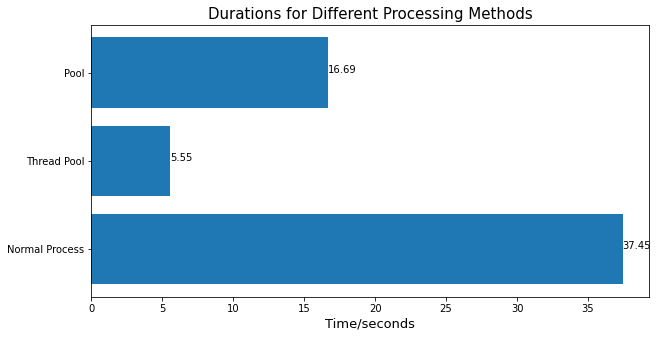

In [9]:
duration = round(duration,2)
a = [duration,duration2,duration3]
aaa = [round(i,2) for i in a]

aa = ['Normal Process','Thread Pool','Pool']

plt.figure(figsize=(10,5))

for index, val in enumerate(aaa):
    plt.text(val,index,str(val))

plt.barh(aa,aaa)
plt.title('Durations for Different Processing Methods',fontsize=15)
plt.xlabel('Time/seconds',fontsize=13)
plt.show()

In [10]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
data.shape,labels.shape,np.unique(labels)

((4072, 224, 224, 3), (4072,), array([0, 1, 2]))

### KNN Method

In [11]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

In [12]:
print(f"Shape of train{trainX.shape,trainY.shape}\nShape of test{testX.shape,testY.shape}")

Shape of train((3257, 224, 224, 3), (3257,))
Shape of test((815, 224, 224, 3), (815,))


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os

In [14]:
Xtr_new = trainX.reshape(trainX.shape[0], 224 * 224 * 3) 
Xte_new = testX.reshape(testX.shape[0], 224*224*3)
print(f"Shape of train{Xtr_new.shape,trainY.shape}\nShape of test{Xte_new.shape,testY.shape}")

Shape of train((3257, 150528), (3257,))
Shape of test((815, 150528), (815,))


              precision    recall  f1-score   support

           0       0.69      0.90      0.78       143
           1       0.50      0.04      0.07        25
           2       0.95      0.92      0.94       647

    accuracy                           0.89       815
   macro avg       0.71      0.62      0.60       815
weighted avg       0.89      0.89      0.88       815



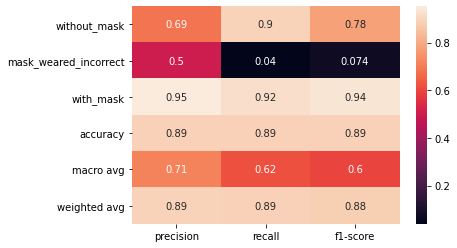

13.336903810501099
Wall time: 13.5 s


In [15]:
%%time
start = time.time()
model = KNeighborsClassifier()
model.fit(np.array(Xtr_new),np.array(trainY))
ypre = model.predict(np.array(Xte_new))

print(classification_report(testY, ypre))
end = time.time()
d=(end-start)

target_names = ['without_mask','mask_weared_incorrect','with_mask']

clf_report = classification_report(testY,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.show()
print(d)

In [16]:
# %%time
# from sklearn.ensemble import RandomForestRegressor

# regressor = RandomForestRegressor()
# regressor.fit(Xtr_new, trainY)
# y_pred = regressor.predict(Xe_new)

In [17]:
# acc_rf = np.mean(y_pred==testY)

In [18]:
# evaluate imbalanced classification model with different metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [19]:
%%time
from sklearn.ensemble import RandomForestClassifier
rfmodel = RandomForestClassifier()
print(rfmodel)
rfmodel.fit(Xtr_new,trainY)
ypre = rfmodel.predict(Xte_new)
print(set(ypre))
acc_rf = np.mean(ypre==testY)
acc_rf


RandomForestClassifier()
{0, 1, 2}
Wall time: 1min 6s


0.9226993865030675

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       143
           1       1.00      0.04      0.08        25
           2       0.94      0.97      0.96       647

    accuracy                           0.92       815
   macro avg       0.93      0.62      0.63       815
weighted avg       0.92      0.92      0.91       815



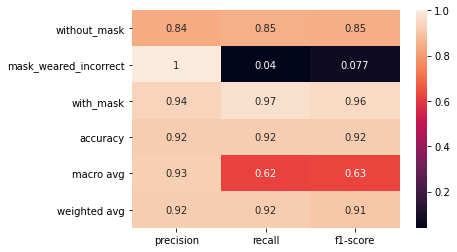

In [20]:
print(classification_report(testY, ypre,zero_division=0))
target_names = ['without_mask','mask_weared_incorrect','with_mask']

clf_report = classification_report(testY,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True,
                                  zero_division=0)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.show()

[0]


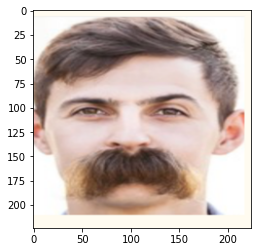

In [21]:
# example_img = load_img(r'/Users/jialingcai/Documents/607_608_project/no_mask_1.png')
# example_img2 = load_img(r'/Users/jialingcai/Documents/607_608_project/with_mask_1.png')
example_img = load_img(APP_FOLDER+'Sample/no_mask_1.png')
example_img2 = load_img(APP_FOLDER+'Sample/with_mask_1.png')

newsize = (224,224)
example_img = example_img.resize(newsize)
#plt.imshow(example_img)
img = img_to_array(example_img)
img = preprocess_input(img)
plt.subplot(1,1,1)
img = img.reshape(1,img.shape[0]*img.shape[1]*img.shape[2])
ypre = model.predict(img)
print(ypre)
plt.imshow(example_img)
plt.show()

* upsample
* downsample

In [22]:
from imblearn.over_sampling import SMOTE
from collections import Counter


In [23]:
oversample = SMOTE()
upX,upY = oversample.fit_resample(Xtr_new,trainY)

In [24]:
counter_original = Counter(trainY)
counter_new = Counter(upY)
print(f'The original Y value count{counter_original}\nThe new Y value count{counter_new}')

The original Y value countCounter({2: 2585, 0: 574, 1: 98})
The new Y value countCounter({2: 2585, 0: 2585, 1: 2585})


RandomForestClassifier()
{0, 1, 2}


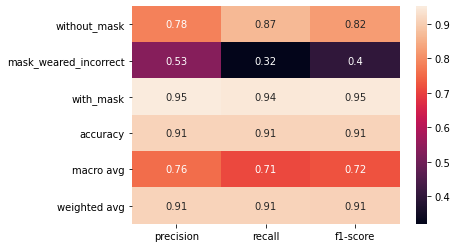

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       143
           1       0.53      0.32      0.40        25
           2       0.95      0.94      0.95       647

    accuracy                           0.91       815
   macro avg       0.76      0.71      0.72       815
weighted avg       0.91      0.91      0.91       815

Wall time: 3min 36s


In [25]:
%%time
from sklearn.ensemble import RandomForestClassifier
import numpy as np
rfmodel = RandomForestClassifier()
print(rfmodel)
rfmodel.fit(np.array(upX),np.array(upY))
ypre = rfmodel.predict(np.array(Xte_new))
print(set(ypre))
acc_rf = np.mean(ypre==testY)
acc_rf
target_names = ['without_mask','mask_weared_incorrect','with_mask']

clf_report = classification_report(testY,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.show()
print(classification_report(testY, ypre))

In [26]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [27]:
under = RandomUnderSampler()
model = RandomForestClassifier()
downX,downY = under.fit_resample(Xtr_new,trainY)
counter_original = Counter(trainY)
counter_new = Counter(downY)
print(f'The original Y value count{counter_original}\nThe new Y value count{counter_new}')

The original Y value countCounter({2: 2585, 0: 574, 1: 98})
The new Y value countCounter({0: 98, 1: 98, 2: 98})


RandomForestClassifier()
{0, 1, 2}
              precision    recall  f1-score   support

           0       0.60      0.80      0.68       143
           1       0.12      0.64      0.20        25
           2       0.98      0.74      0.84       647

    accuracy                           0.74       815
   macro avg       0.57      0.73      0.57       815
weighted avg       0.89      0.74      0.79       815



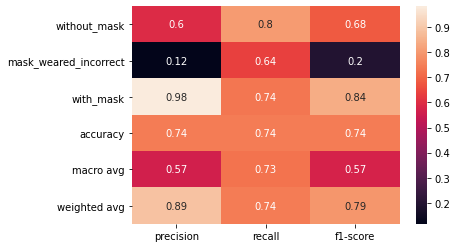

Wall time: 3.19 s


In [66]:
%%time
from sklearn.ensemble import RandomForestClassifier
import numpy as np
rfmodel = RandomForestClassifier()
print(rfmodel)
rfmodel.fit(np.array(downX),np.array(downY))
ypre = rfmodel.predict(np.array(Xte_new))
print(set(ypre))
acc_rf = np.mean(ypre==testY)
acc_rf
print(classification_report(testY, ypre))
target_names = ['without_mask','mask_weared_incorrect','with_mask']

clf_report = classification_report(testY,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.show()

### KNN down & up

              precision    recall  f1-score   support

           0       0.42      0.90      0.57       143
           1       0.07      0.32      0.12        25
           2       0.98      0.61      0.75       647

    accuracy                           0.65       815
   macro avg       0.49      0.61      0.48       815
weighted avg       0.86      0.65      0.70       815



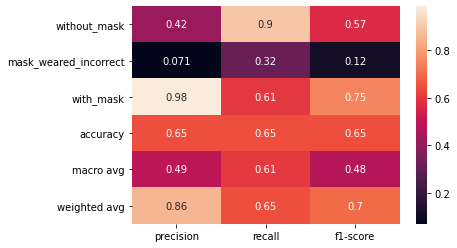

In [67]:
model = KNeighborsClassifier()
model.fit(np.array(downX),np.array(downY))
ypre = model.predict(np.array(Xte_new))

print(classification_report(testY, ypre))

target_names = ['without_mask','mask_weared_incorrect','with_mask']

clf_report = classification_report(testY,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.show()

              precision    recall  f1-score   support

           0       0.53      0.93      0.68       143
           1       0.14      0.60      0.22        25
           2       0.98      0.69      0.81       647

    accuracy                           0.73       815
   macro avg       0.55      0.74      0.57       815
weighted avg       0.88      0.73      0.77       815



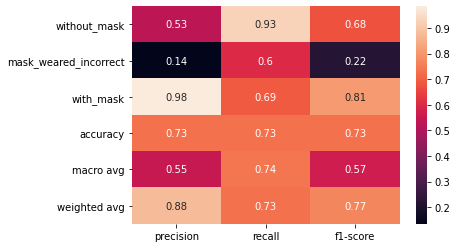

In [68]:
model = KNeighborsClassifier()
model.fit(np.array(upX),np.array(upY))
ypre = model.predict(np.array(Xte_new))

print(classification_report(testY, ypre))

target_names = ['without_mask','mask_weared_incorrect','with_mask']

clf_report = classification_report(testY,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.show()

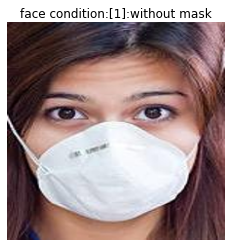

In [72]:
# example_img1 = load_img(r'/Users/jialingcai/Documents/607_608_project/example2.jpeg')
example_img1 = load_img(APP_FOLDER+'Sample/1804_0_face_with_mask.jpg')
newsize = (224,224)
example_img = example_img1.resize(newsize)
#plt.imshow(example_img)
img = img_to_array(example_img)
img = preprocess_input(img)

img = img.reshape(1,img.shape[0]*img.shape[1]*img.shape[2])
ypre = rfmodel.predict(img)

plt.imshow(example_img)
plt.title(f"face condition:{ypre}:without mask")
plt.axis('off')
plt.show()

**Downsampling can provide more accurate result**

In [33]:
import glob
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### KNN with new, balance data conbimed by two datasets/ face with mask or without mask

In [34]:
# path_with_mask = r'/Users/jialingcai/Documents/607_608_project/NewData/face_with_mask'
# path_without_mask = r'/Users/jialingcai/Documents/607_608_project/NewData/face_no_mask'
path_with_mask=NEW_DATA_FOLDER+'face_with_mask/'
path_without_mask=NEW_DATA_FOLDER+'face_no_mask/'

files_with_mask = os.listdir(path_with_mask)
files_without_mask = os.listdir(path_without_mask)
print(files_with_mask[1])

1803_0_face_with_mask.jpg


In [35]:
%%time
def get_image_info(img_path):
    image_obj = load_img(img_path)
    newsize=(224,224)
    new_img_info = image_obj.resize(newsize)

    return (new_img_info)

X1 = []
# X_without_mask=[]
# y_label_without=[]

for i in range(2286):
    j = 1
    img_path = join(path_without_mask,files_without_mask[i])#path_with_mask+'/'+files_with_mask[i]
    x = get_image_info(img_path)
    image = img_to_array(x)
    X1.append({'name': j , 'value': image })
#     X_without_mask.append(image)
#     y_label_without.append(j)
    
# X_without_mask = np.array(X_without_mask)
# X_without_mask.shape

Wall time: 3.99 s


In [36]:
X1 = np.array(X1)
X1[1].get('name')
X1[1].get('value').shape

(224, 224, 3)

In [37]:
%%time
X0=[]
for i in range(2286):
    j=0
    img_path = join(path_with_mask,files_with_mask[i])#path_with_mask+'/'+files_with_mask[i]
    x = get_image_info(img_path)
    image = img_to_array(x)
    X0.append({'name': j , 'value': image })
#     X_with_mask.append(image)
#     y_label_with.append(j)

Wall time: 6.64 s


In [38]:
X0 = np.array(X0)

In [39]:
import random
np.random.seed(42)
data = np.concatenate((X1,X0),axis=0)
data.shape
random.shuffle(data)
data.shape
#WE LABEL WITHMASK AS 1, WITHOUT MASK AS 0
X = [data[i].get('value') for i in range(2286*2)]
np.array(X).shape
#print(data[1])

(4572, 224, 224, 3)

### Random Forest2

In [40]:
%%time
from sklearn.ensemble import RandomForestClassifier


X_tr, X_te, y_tr, y_te = train_test_split(np.array([data[i].get('value') for i in range(2286*2)]), 
                                          np.array([data[i].get('name') for i in range(2286*2)]),
                                          stratify=np.array([data[i].get('name') for i in range(2286*2)]),
                                         test_size=0.3,
                                         random_state=42)
X_tr.shape,y_tr.shape
X_tr = X_tr.reshape(X_tr.shape[0],X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3])
X_te = X_te.reshape(X_te.shape[0],X_te.shape[1]*X_te.shape[2]*X_te.shape[3])

rfmodel2 = RandomForestClassifier(
                                 )
print(rfmodel2)
rfmodel2.fit(X_tr,y_tr)
ypre = rfmodel2.predict(X_te)
print(set(ypre))
acc_rf2 = np.mean(ypre==y_te)
acc_rf2
target_names = ['with_mask','without_mask']

clf_report = classification_report(y_te,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True)


RandomForestClassifier()
{0, 1}
Wall time: 1min 12s


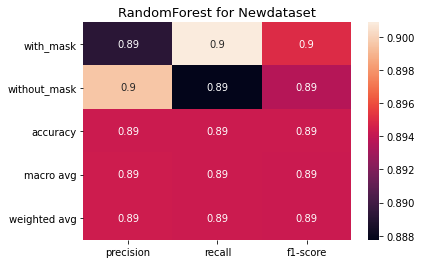

In [41]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title('RandomForest for Newdataset',fontsize=13)
plt.show()

In [42]:
print(classification_report(y_te, ypre))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       686
           1       0.90      0.89      0.89       686

    accuracy                           0.89      1372
   macro avg       0.89      0.89      0.89      1372
weighted avg       0.89      0.89      0.89      1372



{0, 1}


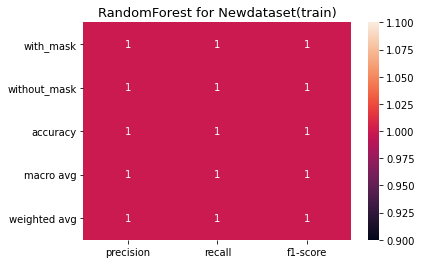

In [43]:
ypre_train = rfmodel2.predict(X_tr)
print(set(ypre))
acc_rf2 = np.mean(ypre_train==y_tr)
acc_rf2
target_names = ['with_mask','without_mask']

clf_report = classification_report(y_tr,
                                   ypre_train,
                                   target_names=target_names,
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title('RandomForest for Newdataset(train)',fontsize=13)
plt.show()

### KNN 2

In [44]:

X_tr, X_te, y_tr, y_te = train_test_split(np.array([data[i].get('value') for i in range(2286*2)]), 
                                          np.array([data[i].get('name') for i in range(2286*2)]),
                                         test_size=0.2,
                                          random_state=42,
                                          stratify=np.array([data[i].get('name') for i in range(2286*2)])
                                         )
X_tr.shape,y_tr.shape
X_tr = X_tr.reshape(X_tr.shape[0],X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3])
X_te = X_te.reshape(X_te.shape[0],X_te.shape[1]*X_te.shape[2]*X_te.shape[3])

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_tr,y_tr)
ypre = model.predict(X_te)
target_names = ['with_mask','without_mask']

clf_report = classification_report(y_te,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True)


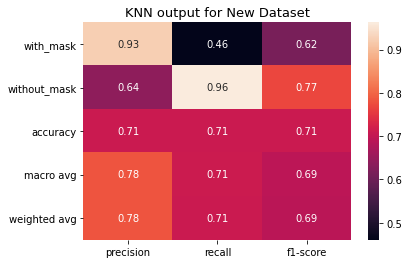

In [45]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title("KNN output for New Dataset",fontsize=13)
plt.show()

In [46]:
print(classification_report(y_te, ypre))

              precision    recall  f1-score   support

           0       0.93      0.46      0.62       458
           1       0.64      0.96      0.77       457

    accuracy                           0.71       915
   macro avg       0.78      0.71      0.69       915
weighted avg       0.78      0.71      0.69       915



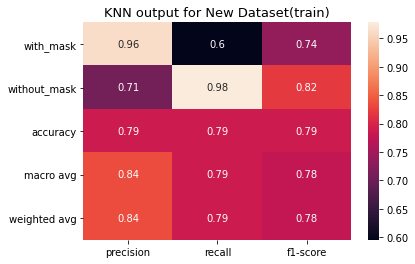

In [47]:
ypre__train = model.predict(X_tr)
target_names = ['with_mask','without_mask']

clf_report = classification_report(y_tr,
                                   ypre__train,
                                   target_names=target_names,
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title("KNN output for New Dataset(train)",fontsize=13)
plt.show()

In [48]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_tr,y_tr)
ypre = model.predict(X_tr)
target_names = ['with_mask','without_mask']

clf_report = classification_report(y_tr,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True)
print(classification_report(y_tr, ypre))

              precision    recall  f1-score   support

           0       0.96      0.60      0.74      1828
           1       0.71      0.98      0.82      1829

    accuracy                           0.79      3657
   macro avg       0.84      0.79      0.78      3657
weighted avg       0.84      0.79      0.78      3657



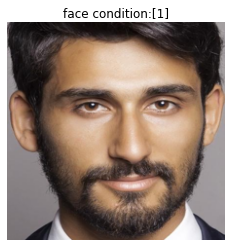

In [49]:
# example_img1 = load_img(r'/Users/jialingcai/Documents/607_608_project/example2.jpeg')
example_img1 = load_img(APP_FOLDER+'Sample/1801_0_face_no_mask.jpg')

newsize = (224,224)
example_img = example_img1.resize(newsize)
#plt.imshow(example_img)
img = img_to_array(example_img)
img = preprocess_input(img)

img = img.reshape(1,img.shape[0]*img.shape[1]*img.shape[2])



ypre = rfmodel2.predict(img)

plt.imshow(example_img)
plt.title(f"face condition:{ypre}")
plt.axis('off')
plt.show()


### dataset2 Json file

In [50]:
import pandas as pd
import glob
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image
import numpy as np


In [51]:
# paths = glob.glob('/Users/jialingcai/Documents/607_608_project/Mask_data_set_2/Medical mask/Medical mask/Medical Mask/annotations/*.json')

In [52]:
# datas=[]
# def read_json(paths):
#     for i in paths:
#         data = pd.read_json(i,lines = True)
#         datas.append(data)
#     df = pd.concat(datas,ignore_index = True)
#     return df

In [53]:


# dataframe = read_json(paths)

In [54]:
# dataframe

In [55]:
df = pd.read_csv(METADATA_FOLDER+'train.csv')
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [56]:
df = df.sort_values('name')

In [57]:
df.head()

,name,x1,x2,y1,y2,classname
13381,1801.jpg,451,186,895,697,face_no_mask
3464,1802.jpg,160,151,268,265,mask_surgical
3463,1802.jpg,110,71,273,272,face_with_mask
14836,1803.jpg,147,200,288,320,mask_surgical
14835,1803.jpg,126,75,303,333,face_with_mask


In [58]:
df['name'][1]
df[df['name']==df['name'][1]]['classname']
df[df['name']==df['name'][0]]['x1'][0]

69

In [59]:
def get_img_dataset2 (index):
    img_name = df['name'][index]
    classname = df[df['name']==img_name]['classname'][index]
    x1 = df[df['name']==img_name]['x1'][index]
    x2 = df[df['name']==img_name]['x2'][index]
    y1 = df[df['name']==img_name]['y1'][index]
    y2 = df[df['name']==img_name]['y2'][index]
#     img_path = r'/Users/jialingcai/Documents/607_608_project/Mask_data_set_2/Medical mask/Medical mask/Medical Mask/images'
    img_path = DATASET2_PATH+'Medical mask/Medical mask/Medical Mask/images'
    imge = plt.imread(os.path.join(img_path,img_name))
    return (img_name,classname,x1,x2,y1,y2,imge)

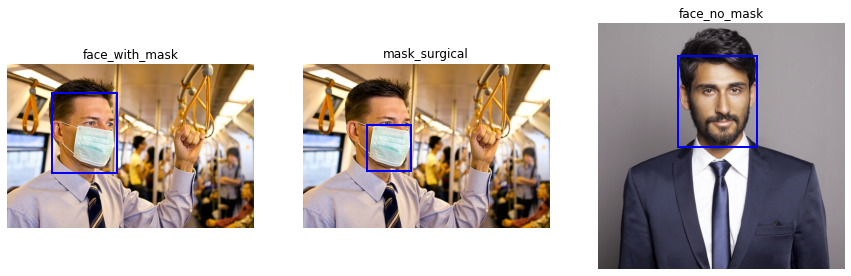

In [60]:
fig,[ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

img_name,classname,x1,x2,y1,y2,imge = get_img_dataset2(13381)
#fig, axs = plt.subplots(1, 3, figsize=(9, 3))
ax3.set_title(f'{classname}')
rect = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='b',facecolor='none')
ax3.add_patch(rect)
ax3.set_axis_off()
ax3.imshow(imge)
#face with no mask


img_name,classname,x1,x2,y1,y2,imge = get_img_dataset2(3463)

ax1.set_title(f'{classname}')
rect = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='b',facecolor='none')
ax1.add_patch(rect)
ax1.set_axis_off()
ax1.imshow(imge)

img_name,classname,x1,x2,y1,y2,imge = get_img_dataset2(3464)
ax2.set_title(f'{classname}')
rect = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='b',facecolor='none')
ax2.add_patch(rect)
ax2.set_axis_off()
ax2.imshow(imge)
#face with mask

plt.show()

In [61]:
df.loc[df['classname']=='face_other_covering']

,name,x1,x2,y1,y2,classname
4837,1807.jpg,700,165,1802,1525,face_other_covering
643,1817.jpg,382,47,511,244,face_other_covering
1814,1820.jpg,745,1083,1228,1713,face_other_covering
8367,1821.jpg,130,136,227,240,face_other_covering
13713,1824.jpeg,90,78,301,307,face_other_covering
...,...,...,...,...,...,...
3351,6408.png,577,74,1005,843,face_other_covering
9354,6412.png,202,69,449,430,face_other_covering
11488,6413.png,96,94,540,533,face_other_covering
9322,6416.png,96,65,363,455,face_other_covering


In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import os
import tensorflow as tf

In [63]:
# new_model = tf.keras.models.load_model('Dataset2_MobileNetV2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


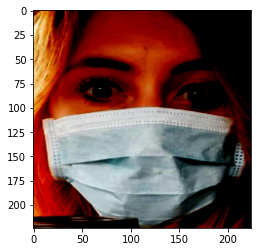

In [64]:
# example_img = load_img(r'/Users/jialingcai/Documents/607_608_project/example3.jpeg')
example_img = load_img(APP_FOLDER+'Sample/with_mask_4.png')
newsize = (224,224)
example_img = example_img.resize(newsize)
#plt.imshow(example_img)
img = img_to_array(example_img)
img = preprocess_input(img)
plt.imshow(img)
img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])

In [ ]:
# ypre = new_model.predict(img)

In [ ]:
# print(ypre)